# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
from PIL import Image
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size, max_samples):
    print('Source path = ', source_path, '; batch size =', batch_size)
    num_frames_to_select = 30
    img_idx = list(range(num_frames_to_select))

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size  # Full batches
        num_remaining = len(folder_list) % batch_size  # Remaining items for last batch

        # Calculate the total number of samples to generate
        if max_samples is None:
            total_samples = len(folder_list)
        else:
            total_samples = min(max_samples, len(folder_list))

        for batch in range(num_batches):
            if batch * batch_size >= total_samples:
                break  # Stop if we've reached the specified maximum samples
            batch_data = np.zeros((batch_size, z, y, x, 3))
            batch_labels = np.zeros((batch_size, 5))
            for folder in range(batch_size):
                if folder + (batch * batch_size) >= total_samples:
                    break  # Stop if we've reached the specified maximum samples
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    img_path = os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])
                    image = Image.open(img_path)
                    image = image.resize((x, y))
                    image = np.array(image).astype(np.float32) / 255.0
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        # Handling the remaining data points
        if num_remaining > 0 and (max_samples is None or (batch + 1) * batch_size < total_samples):
            batch_data = np.zeros((num_remaining, z, y, x, 3))
            batch_labels = np.zeros((num_remaining, 5))
            for folder in range(num_remaining):
                if folder + (num_batches * batch_size) >= total_samples:
                    break  # Stop if we've reached the specified maximum samples
                imgs = os.listdir(os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0]))
                for idx, item in enumerate(img_idx):
                    img_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].strip().split(';')[0], imgs[item])
                    image = Image.open(img_path)
                    image = image.resize((x, y))
                    image = np.array(image).astype(np.float32) / 255.0
                    batch_data[folder, idx, :, :, :] = image
                batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train/'
val_path = '/home/datasets/Project_data/val/'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
#write your model here

x = 100  # Number of rows in the image
y = 100  # Number of columns in the image
z = 30   # Number of frames used from each video
# Model parameters
input_shape = (z, y, x, 3)
num_classes = 5

model = Sequential()

# First layer - Conv3D
model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second layer - Conv3D
model.add(Conv3D(64, (3, 3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

2023-12-27 10:19:42.920417: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-12-27 10:19:42.920479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
optimiser = Adam(learning_rate=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 98, 98, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 28, 98, 98, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 49, 49, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 47, 47, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 47, 47, 64)   256       
 hNormalization)                                                 
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
max_sample = 300

train_generator = generator(train_path, train_doc, batch_size, max_sample)
val_generator = generator(val_path, val_doc, batch_size, 100)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Define the ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train/ ; batch size = 30
Epoch 1/25


2023-12-27 06:08:48.498293: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 26.6861 - categorical_accuracy: 0.3768Source path =  /home/datasets/Project_data/val/ ; batch size = 30

Epoch 00001: saving model to model_init_2023-12-2706_06_45.143002/model-00001-26.68607-0.37681-32.85888-0.18000.h5
23/23 [==============================] - 98s 4s/step - loss: 26.6861 - categorical_accuracy: 0.3768 - val_loss: 32.8589 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 6.2529 - categorical_accuracy: 0.3783
Epoch 00002: saving model to model_init_2023-12-2706_06_45.143002/model-00002-6.25288-0.37826-12.54874-0.32000.h5
23/23 [==============================] - 100s 5s/step - loss: 6.2529 - categorical_accuracy: 0.3783 - val_loss: 12.5487 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.9786 - categorical_accuracy: 0.4188
Epoch 00003: saving model to model_init_2023-12-2706_06_45.14

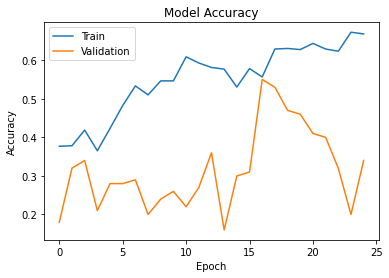

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

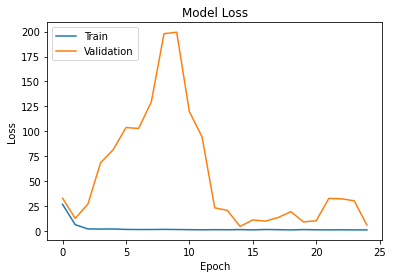

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Observations:
- Training accuracy plateaus at 50%
- Validation accuracy is lower and fluctuates, indicating overfitting and poor generalization.
- The accuracy gap and validation fluctuations imply a need for improved generalization methods.
- Training and validation losses are initially high but the training loss drops sharply after the first epoch.
- Validation loss shows large fluctuations post-initial drop, hinting at potential generalization issues.
- There's a general downward trend in loss, indicating that the model is learning over time.

Actions
- Improve Data Augmentation
- Modify Learning Rate
- Batch Size Adjustment
- Update Model Architecture
- Adding dropout before a dense layer

Experiment 2

Improve Data Augmenation

In [6]:
import random
from scipy import ndimage

def generator_updated(source_path, folder_list, batch_size, max_samples):
    print('Source path = ', source_path, '; batch size =', batch_size)
    num_frames_to_select = 30
    img_idx = list(range(num_frames_to_select))

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size  # Full batches
        num_remaining = len(folder_list) % batch_size  # Remaining items for last batch

        # Calculate the total number of samples to generate
        total_samples = len(folder_list) if max_samples is None else min(max_samples, len(folder_list))

        for batch in range(num_batches):
            if batch * batch_size >= total_samples:
                break
            batch_data = np.zeros((batch_size, num_frames_to_select, y, x, 3))
            batch_labels = np.zeros((batch_size, 5))
            for folder in range(batch_size):
                if folder + (batch * batch_size) >= total_samples:
                    break
                imgs = sorted(os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]))[:num_frames_to_select]
                
                # Temporal augmentation: Random start
                start_frame = random.randint(0, len(imgs) - num_frames_to_select)
                imgs = imgs[start_frame:start_frame + num_frames_to_select]

                # Spatial augmentation: Random horizontal flip
                do_horizontal_flip = random.random() < 0.5
                for idx, img_name in enumerate(imgs):
                    img_path = os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], img_name)
                    image = Image.open(img_path).resize((x, y))
                    if do_horizontal_flip:
                        image = image.transpose(Image.FLIP_LEFT_RIGHT)
                    # Apply a random rotation
                    angle = random.uniform(-10, 10)
                    image = ndimage.rotate(np.array(image), angle, reshape=False)
                    batch_data[folder, idx, :, :, :] = np.clip(image / 255.0, 0, 1)  # Normalize and clip

                # One-hot encode labels
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        # Handle the remaining data points
        if num_remaining > 0 and (max_samples is None or (batch + 1) * batch_size < total_samples):
            batch_data = np.zeros((num_remaining, num_frames_to_select, y, x, 3))
            batch_labels = np.zeros((num_remaining, 5))
            for folder in range(num_remaining):
                if folder + (num_batches * batch_size) >= total_samples:
                    break
                imgs = sorted(os.listdir(os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0])))[:num_frames_to_select]
                
                # Temporal and spatial augmentation as before
                start_frame = random.randint(0, len(imgs) - num_frames_to_select)
                imgs = imgs[start_frame:start_frame + num_frames_to_select]
                do_horizontal_flip = random.random() < 0.5
                for idx, img_name in enumerate(imgs):
                    img_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].strip().split(';')[0], img_name)
                    image = Image.open(img_path).resize((x, y))
                    if do_horizontal_flip:
                        image = image.transpose(Image.FLIP_LEFT_RIGHT)
                    angle = random.uniform(-10, 10)
                    image = ndimage.rotate(np.array(image), angle, reshape=False)
                    batch_data[folder, idx, :, :, :] = np.clip(image / 255.0, 0, 1)
                
                batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [18]:
num_epochs = 40
max_sample = None
batch_size = 16

train_generator = generator_updated(train_path, train_doc, batch_size, max_sample)
val_generator = generator_updated(val_path, val_doc, batch_size, 100)

In [19]:
model = Sequential()

# First layer - Conv3D
model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second layer - Conv3D
model.add(Conv3D(64, (3, 3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

In [20]:
optimiser = Adam(learning_rate=0.0001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 28, 98, 98, 32)    2624      
                                                                 
 batch_normalization_2 (Batc  (None, 28, 98, 98, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 14, 49, 49, 32)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 12, 47, 47, 64)    55360     
                                                                 
 batch_normalization_3 (Batc  (None, 12, 47, 47, 64)   256       
 hNormalization)                                                 
                                                      

In [22]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train/ ; batch size = 16
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 6.1814 - categorical_accuracy: 0.3071Source path =  /home/datasets/Project_data/val/ ; batch size = 16

Epoch 00001: saving model to model_init_2023-12-2706_06_45.143002/model-00001-6.18141-0.30707-1.74936-0.21875.h5
23/23 [==============================] - 109s 5s/step - loss: 6.1814 - categorical_accuracy: 0.3071 - val_loss: 1.7494 - val_categorical_accuracy: 0.2188 - lr: 1.0000e-04
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.9387 - categorical_accuracy: 0.2953
Epoch 00002: saving model to model_init_2023-12-2706_06_45.143002/model-00002-1.93873-0.29526-1.58201-0.32692.h5
23/23 [==============================] - 104s 5s/step - loss: 1.9387 - categorical_accuracy: 0.2953 - val_loss: 1.5820 - val_categorical_accuracy: 0.3269 - lr: 1.0000e-04
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 1.6470 - categoric

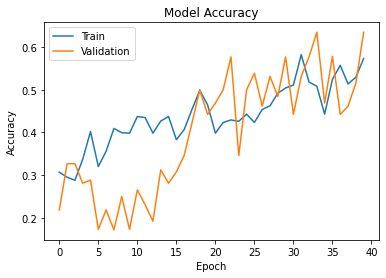

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

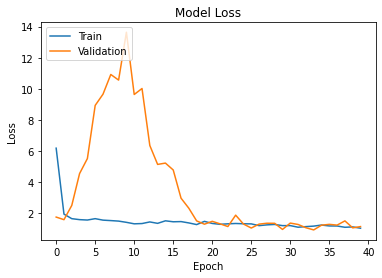

In [24]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Observation 
- Learning Progress: Both the training and validation accuracies are improving over time, which indicates that the model is learning and benefiting from the training process.
- Potential for Improvement: The training accuracy has not plateaued by the 30th epoch, indicating that the model may continue to improve with additional training.

Next Step
- Continuing training for more epochs until the training accuracy plateaus or until the validation accuracy begins to decrease, indicating overfitting.

Experiment 3
 Increase no. of epoch to 45

In [26]:
num_epochs = 40
max_sample = None
batch_size = 20

train_generator = generator_updated(train_path, train_doc, batch_size, max_sample)
val_generator = generator_updated(val_path, val_doc, batch_size, 100)

In [27]:
model = Sequential()

# First layer - Conv3D
model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second layer - Conv3D
model.add(Conv3D(64, (3, 3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

In [28]:
optimiser = Adam(learning_rate=0.0001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 28, 98, 98, 32)    2624      
                                                                 
 batch_normalization_7 (Batc  (None, 28, 98, 98, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 14, 49, 49, 32)   0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 12, 47, 47, 64)    55360     
                                                                 
 batch_normalization_8 (Batc  (None, 12, 47, 47, 64)   256       
 hNormalization)                                                 
                                                      

In [29]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train/ ; batch size = 20
Epoch 1/40
42/42 [==============================] - ETA: 0s - loss: 3.3725 - categorical_accuracy: 0.3402Source path =  /home/datasets/Project_data/val/ ; batch size = 20

Epoch 00001: saving model to model_init_2023-12-2710_19_38.154816/model-00001-3.37251-0.34022-2.80261-0.17857.h5
42/42 [==============================] - 222s 5s/step - loss: 3.3725 - categorical_accuracy: 0.3402 - val_loss: 2.8026 - val_categorical_accuracy: 0.1786 - lr: 1.0000e-04
Epoch 2/40
42/42 [==============================] - ETA: 0s - loss: 1.4644 - categorical_accuracy: 0.3827
Epoch 00002: saving model to model_init_2023-12-2710_19_38.154816/model-00002-1.46444-0.38275-5.12621-0.21429.h5
42/42 [==============================] - 221s 5s/step - loss: 1.4644 - categorical_accuracy: 0.3827 - val_loss: 5.1262 - val_categorical_accuracy: 0.2143 - lr: 1.0000e-04
Epoch 3/40
42/42 [==============================] - ETA: 0s - loss: 1.4099 - categoric

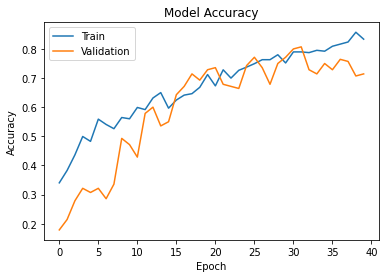

In [30]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

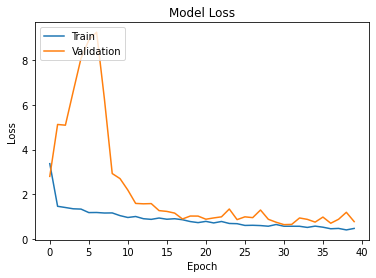

In [31]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Conculsuion

Training Accuracy:
The training accuracy is consistently increasing, which indicates that the model is learning from the training data.
It starts from below 0.2 and rises to just above 0.8 by the 40th epoch.
There's a steady progression with no significant plateaus or drops, suggesting that the model could potentially continue to learn with more epochs.

Validation Accuracy:
The validation accuracy also increases, but at a slower rate compared to the training accuracy.
It begins at around 0.1 and appears to plateau near 0.7 after approximately 30 epochs.
There are fluctuations in the validation accuracy, but this is common in validation curves.